### Workspace

In [1]:
%matplotlib notebook

from modsim import *

In [2]:
altitude = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 
            8000, 9000, 10000, 15000, 20000, 25000, 30000,
           40000, 50000, 60000, 70000, 80000]
density = [1.225, 1.112, 1.007, .9093, .8194, .7364, .6601,
          .5900, .5258, .4671, .4135, .1948, .08891, .04008,
          .01841, .003996, .001027, .0003097, .00008283, .000001846]

dd_da = TimeSeries()
for i in range(20):
    x = altitude[i]
    y = density[i]
    dd_da[x] = y

dd_da = interpolate(dd_da, kind='cubic')

In [3]:
condition = Condition(height=90000,
                      thrust_on=200,
                      f_thrust=20,
                      mass=1,
                      length=.1,
                      width=.1,
                      dd_da=dd_da,
                      C_d=1,
                      g=9.8,
                      dt=1,
                      t_end=500)

In [4]:
def make_system(condition):
    unpack(condition)
    
    init = State(height=height, velocity=0)
    
    drag_coef = -C_d*length*width / 2
    
    system = System(init=init,
                    dt=dt,
                    thrust_on=thrust_on,
                    f_thrust=f_thrust,
                    mass=mass,
                    drag_coef=drag_coef,
                    dd_da=dd_da)
    return system

def slope(state, system, dt, count):
    unpack(system)
    height, velocity = state
    
    if (height < thrust_on):
        f_t=f_thrust
    else:
        f_t=0
    
    f_drag = drag_coef * abs(velocity) * velocity * abs(dd_da(height))
    #print(f_drag)
    a_drag = f_drag/mass

    a_thrust = f_t/mass
    a_grav = -g
    a = a_grav + a_thrust + a_drag
    dV = a*dt
    velocity += dV
    
    dH = velocity*dt
    height += dH
         
    return State(height=height, velocity=velocity)

def run_ode_better(system, slope_func):
    count = 0
    unpack(system)
    frame = TimeFrame(columns=init.index)
    
    frame.loc[0] = init
    for i in series:
        if(i < t_end):
            frame.loc[i+dt] = slope_func(frame.loc[i], system, dt, count)
        else:
            system.results = frame
        count += 1
    system.count = count
    
def run_ode_best(system, slope_func):
    count = 0
    unpack(system)
    frame = TimeFrame(columns=init.index)
    
    frame.loc[0] = init
    while(frame.loc[count].velocity <= 0):
        frame.loc[count+dt] = slope_func(frame.loc[count], system, dt, count)
        count += dt
    system.count = count
    system.results = frame
    
def plot_height(results):
    newfig()
    unpack(results)
    
    plot(height, label='y')
        
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')

    
def plot_velocity(results):
    newfig()
    unpack(results)
    
    plot(velocity, label='v')
    
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m)')
    
def height_at_zero(system):
    unpack(system)
    t_end = system.count
    t_start = system.count - system.dt
    height = (system.results.height[t_start] + system.results.height[t_end])/2
    return height

def run_simulation(t_on):
    system = make_system(condition)
    condition.set(thrust_on = t_on)
    run_ode_best(system, slope)
    #print(system.thrust_on)
    system.final_height = height_at_zero(system)
    
    return system

In [5]:
condition.set(dt=.1)
#condition.set(t_end = 300)
condition.set(height = 1000)

run1 = run_simulation(500)

In [6]:
print(run1.final_height)

144.390768795


<IPython.core.display.Javascript object>


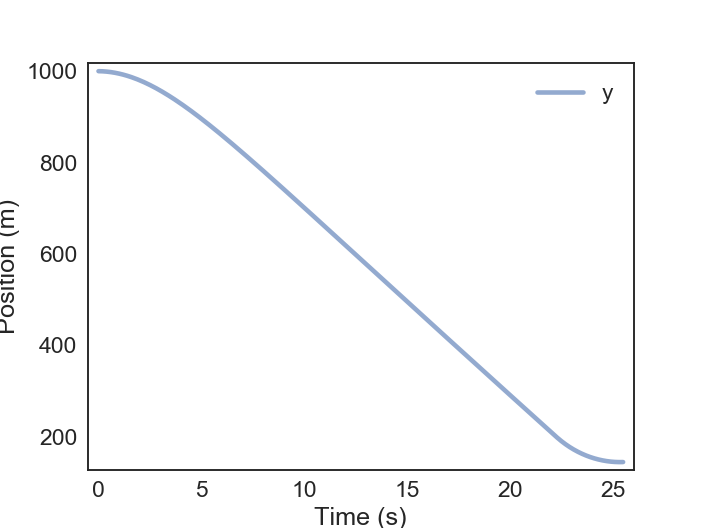

In [7]:
plot_height(run1.results)

<IPython.core.display.Javascript object>


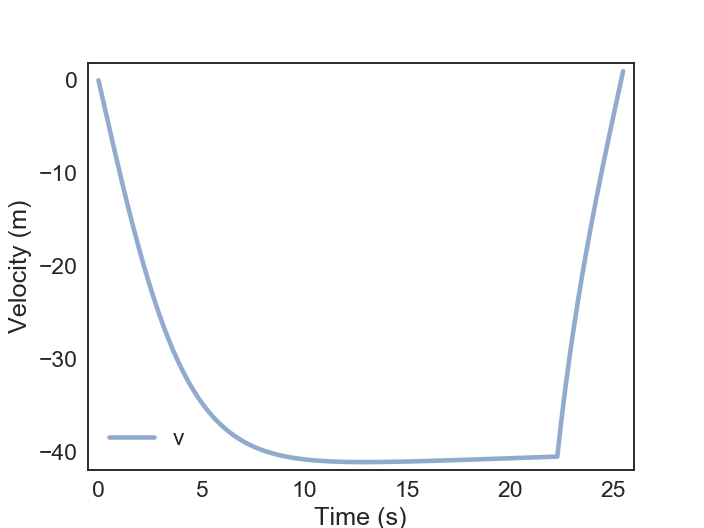

In [8]:
plot_velocity(run1.results)

In [9]:
sweep = SweepSeries()
condition.set(dt=.1)
condition.set(thrust_on = 0)
condition.set(height=10000)
for thrust in linrange(4, 100, 4):
    system57 = run_simulation(thrust)
    print(system57.thrust_on)
    print(system57.final_height)
    #print(system57.t1)
    #print(system.results.height[system.t_end])
    sweep[thrust] = system57.final_height

0
-54.2433980819
4.0
-50.2488735418
8.0
-46.2535792102


KeyError: 'the label [91.39999999999908] is not in the [index]'

In [ ]:
newfig()
plot(sweep, 'ro')
decorate(xlabel='thrust on',
         ylabel='Height at 0 velocity',
         legend=False)

In [ ]:
sweep

In [10]:
linrange(1, 100, 4)

array([   1.  ,    4.96,    8.92,   12.88,   16.84,   20.8 ,   24.76,
         28.72,   32.68,   36.64,   40.6 ,   44.56,   48.52,   52.48,
         56.44,   60.4 ,   64.36,   68.32,   72.28,   76.24,   80.2 ,
         84.16,   88.12,   92.08,   96.04,  100.  ])

In [11]:
def thrust_at_height(sweep):
    t = interp_inverse(sweep)
    height_thrust = t(0)
    return height_thrust

In [12]:
thrust_at_height(sweep)

array(58.30805680009275)

In [15]:
sweep_height = SweepSeries()
condition.set(dt=.06)
condition.set(thrust_on = 0)
for i in linspace(1000, 30000, 10):
    sweep_thrust = SweepSeries()
    condition.set(height=i)
    print("height: ", i)
    for thrust in linspace(20, 100, 20):
        system57 = run_simulation(thrust)
        sweep_thrust[thrust] = system57.final_height
        print("    thrust_on: ", system57.thrust_on)
    print(thrust_at_height(sweep_thrust))
    sweep_height[i] = thrust_at_height(sweep_thrust)

height:  1000.0
    thrust_on:  0
    thrust_on:  20.0
    thrust_on:  24.2105263158
    thrust_on:  28.4210526316
    thrust_on:  32.6315789474
    thrust_on:  36.8421052632
    thrust_on:  41.0526315789
    thrust_on:  45.2631578947
    thrust_on:  49.4736842105
    thrust_on:  53.6842105263
    thrust_on:  57.8947368421
    thrust_on:  62.1052631579
    thrust_on:  66.3157894737
    thrust_on:  70.5263157895
    thrust_on:  74.7368421053
    thrust_on:  78.9473684211
    thrust_on:  83.1578947368
    thrust_on:  87.3684210526
    thrust_on:  91.5789473684
    thrust_on:  95.7894736842
58.78081228287819
height:  4222.22222222
    thrust_on:  100.0
    thrust_on:  20.0
    thrust_on:  24.2105263158
    thrust_on:  28.4210526316
    thrust_on:  32.6315789474
    thrust_on:  36.8421052632
    thrust_on:  41.0526315789
    thrust_on:  45.2631578947
    thrust_on:  49.4736842105
    thrust_on:  53.6842105263
    thrust_on:  57.8947368421
    thrust_on:  62.1052631579
    thrust_on:  66.31

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


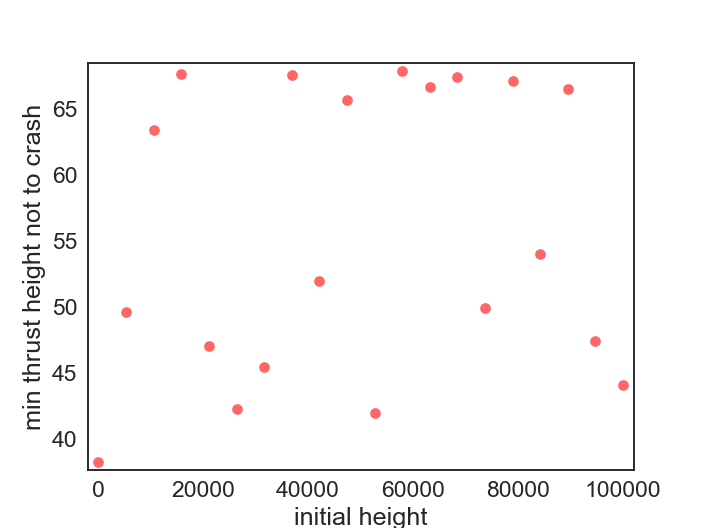

In [125]:
newfig()
plot(sweep_height, 'ro')
decorate(xlabel='initial height',
         ylabel='min thrust height not to crash',
         legend=False)